# Bagmati catchment
## Based on the results from MLP exhaustive optimization(04Feb2023)
### Standard normalization
#### Note: AOE(After Exhaustive Optimization)



In [7]:
import numpy as np
import pandas as pd

### define file path
path = 'Non_scaled_6_input_Bagmati_yr.csv'  ####### This excel data is not scaled/normalized
## Read CSV file and convert it to dataframe
df = pd.read_csv( path, sep = ',', header = 'infer')

In [8]:
df

,Rt,Rt_1,Rt_2,Rt_3,Rt_4,Rt_5,Qt
0,0.878,25.060,3.613,8.190,1.608,28.160,299.0
1,0.000,0.878,25.060,3.613,8.190,1.608,182.0
2,25.527,0.000,0.878,25.060,3.613,8.190,151.0
3,36.896,25.527,0.000,0.878,25.060,3.613,561.0
4,6.184,36.896,25.527,0.000,0.878,25.060,384.0
...,...,...,...,...,...,...,...
2909,7.115,0.422,7.130,13.781,4.314,18.381,132.0
2910,3.118,7.115,0.422,7.130,13.781,4.314,107.0
2911,61.877,3.118,7.115,0.422,7.130,13.781,538.0
2912,112.900,61.877,3.118,7.115,0.422,7.130,921.0


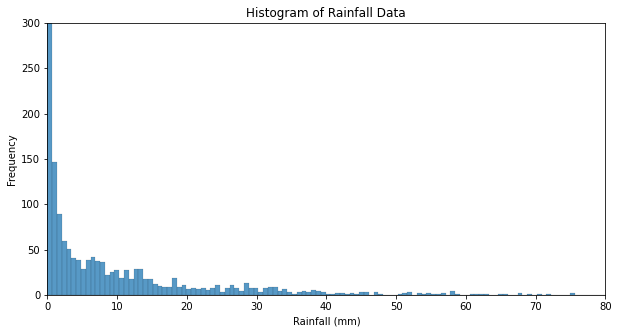

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
# Plot the distribution of rainfall data as a histogram
sns.histplot(df["Rt"], kde=False)

# Add labels and title to the plot
plt.xlabel("Rainfall (mm)")
plt.ylabel("Frequency")
plt.title("Histogram of Rainfall Data")
plt.xlim(0, 80)
plt.ylim(0, 300)
plt.show()

# i. Data splitting

##  Train, Validation and Test data 
###  70% train (2040 data points)
###  15% train (436 data points)
###  15% train (436 data points)

In [10]:
df_train = df.iloc[:2040]

df_val = df.iloc[2040:2476] 

df_test = df.iloc[2476:2912] 

# ii. Normalization

In [11]:
import pandas as pd
import numpy as np

### General function for all the normalization methods

def normalize_df(data, norm_method):     

    ## Normalize data using specified method
 
    if norm_method == 'minmax':
        # Min-Max normalization
        data = (data - data.min()) / (data.max() - data.min())
    elif norm_method == 'zscore':
        # Z-score normalization
        mean = data.mean()
        std = data.std()
        data = (data - mean) / std
    elif norm_method == 'max':
        # Max normalization
        data = 1 - ((data.max() - data)/data.max())
    else:
        raise ValueError("Invalid normalization method. Choose from: 'minmax', 'zscore', 'max'")
    return data

### Standard normalization  (Date sets for training, validation and testing are nromalized separately)

In [12]:
#### This is for cross checking scaling before and after data splitting
df_scaled = normalize_df(df, 'minmax')
df_scaled

,Rt,Rt_1,Rt_2,Rt_3,Rt_4,Rt_5,Qt
0,0.002408,0.068735,0.009910,0.022464,0.004410,0.077237,0.058489
1,0.000000,0.002408,0.068735,0.009910,0.022464,0.004410,0.035205
2,0.070016,0.000000,0.002408,0.068735,0.009910,0.022464,0.029035
3,0.101199,0.070016,0.000000,0.002408,0.068735,0.009910,0.110629
4,0.016962,0.101199,0.070016,0.000000,0.002408,0.068735,0.075404
...,...,...,...,...,...,...,...
2909,0.019515,0.001157,0.019556,0.037799,0.011832,0.050416,0.025254
2910,0.008552,0.019515,0.001157,0.019556,0.037799,0.011832,0.020279
2911,0.169717,0.008552,0.019515,0.001157,0.019556,0.037799,0.106052
2912,0.309663,0.169717,0.008552,0.019515,0.001157,0.019556,0.182272


In [13]:
## Z_score(standard)
df_train_norm = normalize_df(df_train, 'zscore')
df_val_norm = normalize_df(df_val, 'zscore')
df_test_norm = normalize_df(df_test, 'zscore')

In [14]:
### convert the dataframes to numpy arrays

df_train_f = df_train_norm.to_numpy()

df_val_f = df_val_norm.to_numpy()

df_test_f = df_test_norm.to_numpy()

In [15]:
### Define input and output sequences (list of sub sequences)

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
    # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1] 
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps_in, n_steps_out = 1, 1    ####  input sequences and output sequences



In [16]:
#### Training data

# convert into input/output
X_train, y_train = split_sequences(df_train_f, n_steps_in, n_steps_out)
print(X_train.shape, y_train.shape)

# reshape from [samples, timesteps] into [samples, timesteps, features]

n_features = 6

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))


(2040, 1, 6) (2040, 1)


In [17]:
#### validation data

X_val, y_val = split_sequences(df_val_f, n_steps_in, n_steps_out)


X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

### reshape

X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

print(X_val.shape, y_val.shape)


(436, 1, 6) (436, 1)


In [18]:
#### Test data

X_test, y_test = split_sequences(df_test_f, n_steps_in, n_steps_out)

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

print(X_test.shape, y_test.shape)


(436, 1, 6) (436, 1)


In [19]:
#### model fitting
import keras
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import save_model

from tensorflow.keras import initializers

from tensorflow.keras import layers


## iii. Build model (Using model_buider function)
### (https://www.tensorflow.org/tutorials/keras/keras_tuner)
## 1) MLP

In [78]:
#### Define the layers

# tf.random.set_seed(1)   ####for reproducibilty but MLP model results area reproducible even with out this line of code

model = keras.Sequential()

model.add(keras.layers.Flatten(input_shape = (n_steps_in, n_features)))

model.add(keras.layers.Dense(units = 8, activation = 'relu', kernel_initializer = tf.keras.initializers.lecun_normal(seed = 1) )) #### input layer

# model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Dense(units = 1, kernel_initializer = tf.keras.initializers.lecun_normal(seed = 1)))                     #### output layer
# model.add(keras.layers.Dropout(0.1))


In [79]:
### compile
model.compile(optimizer =  'rmsprop', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])


In [80]:
###fit

mlp_amt = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 300, verbose = True, shuffle = False)

Epoch 1/300
64/64 [==============================] - 2s 9ms/step - loss: 0.6273 - mean_squared_error: 0.6273 - val_loss: 0.5283 - val_mean_squared_error: 0.5283
Epoch 2/300
64/64 [==============================] - 0s 6ms/step - loss: 0.5120 - mean_squared_error: 0.5120 - val_loss: 0.4390 - val_mean_squared_error: 0.4390
Epoch 3/300
64/64 [==============================] - 0s 6ms/step - loss: 0.4296 - mean_squared_error: 0.4296 - val_loss: 0.3762 - val_mean_squared_error: 0.3762
Epoch 4/300
64/64 [==============================] - 0s 5ms/step - loss: 0.3722 - mean_squared_error: 0.3722 - val_loss: 0.3364 - val_mean_squared_error: 0.3364
Epoch 5/300
64/64 [==============================] - 0s 6ms/step - loss: 0.3356 - mean_squared_error: 0.3356 - val_loss: 0.3151 - val_mean_squared_error: 0.3151
Epoch 6/300
64/64 [==============================] - 0s 6ms/step - loss: 0.3115 - mean_squared_error: 0.3115 - val_loss: 0.3039 - val_mean_squared_error: 0.3039
Epoch 7/300
64/64 [===============

64/64 [==============================] - 0s 4ms/step - loss: 0.1811 - mean_squared_error: 0.1811 - val_loss: 0.3032 - val_mean_squared_error: 0.3032
Epoch 102/300
64/64 [==============================] - 0s 5ms/step - loss: 0.1809 - mean_squared_error: 0.1809 - val_loss: 0.3033 - val_mean_squared_error: 0.3033
Epoch 103/300
64/64 [==============================] - 0s 6ms/step - loss: 0.1806 - mean_squared_error: 0.1806 - val_loss: 0.3032 - val_mean_squared_error: 0.3032
Epoch 104/300
64/64 [==============================] - 0s 4ms/step - loss: 0.1804 - mean_squared_error: 0.1804 - val_loss: 0.3032 - val_mean_squared_error: 0.3032
Epoch 105/300
64/64 [==============================] - 0s 3ms/step - loss: 0.1802 - mean_squared_error: 0.1802 - val_loss: 0.3030 - val_mean_squared_error: 0.3030
Epoch 106/300
64/64 [==============================] - 0s 4ms/step - loss: 0.1802 - mean_squared_error: 0.1802 - val_loss: 0.3032 - val_mean_squared_error: 0.3032
Epoch 107/300
64/64 [===============

64/64 [==============================] - 0s 4ms/step - loss: 0.1683 - mean_squared_error: 0.1683 - val_loss: 0.3019 - val_mean_squared_error: 0.3019
Epoch 202/300
64/64 [==============================] - 0s 4ms/step - loss: 0.1681 - mean_squared_error: 0.1681 - val_loss: 0.3019 - val_mean_squared_error: 0.3019
Epoch 203/300
64/64 [==============================] - 0s 4ms/step - loss: 0.1679 - mean_squared_error: 0.1679 - val_loss: 0.3019 - val_mean_squared_error: 0.3019
Epoch 204/300
64/64 [==============================] - 0s 4ms/step - loss: 0.1678 - mean_squared_error: 0.1678 - val_loss: 0.3018 - val_mean_squared_error: 0.3018
Epoch 205/300
64/64 [==============================] - 0s 4ms/step - loss: 0.1676 - mean_squared_error: 0.1676 - val_loss: 0.3017 - val_mean_squared_error: 0.3017
Epoch 206/300
64/64 [==============================] - 0s 4ms/step - loss: 0.1675 - mean_squared_error: 0.1675 - val_loss: 0.3019 - val_mean_squared_error: 0.3019
Epoch 207/300
64/64 [===============

### Find best epoch

In [81]:
#### find the best epoch by looking in to the validation loss

val_acc_per_epoch = mlp_amt.history['val_loss']   

#### 'val_loss' should align with the objective function used when applying 'tuner.search' (both should be loss or both accuracy)

best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1

print('Best epoch: %d' % (best_epoch,))

Best epoch: 13


In [82]:
#### model with best epoch 
mlp_amt_be = model.fit(X_train, y_train, epochs= best_epoch, verbose = 1, validation_data=(X_val, y_val), shuffle = False) 

Epoch 1/13
64/64 [==============================] - 0s 6ms/step - loss: 0.1559 - mean_squared_error: 0.1559 - val_loss: 0.3031 - val_mean_squared_error: 0.3031
Epoch 2/13
64/64 [==============================] - 0s 5ms/step - loss: 0.1559 - mean_squared_error: 0.1559 - val_loss: 0.3030 - val_mean_squared_error: 0.3030
Epoch 3/13
64/64 [==============================] - 0s 6ms/step - loss: 0.1558 - mean_squared_error: 0.1558 - val_loss: 0.3032 - val_mean_squared_error: 0.3032
Epoch 4/13
64/64 [==============================] - 0s 4ms/step - loss: 0.1558 - mean_squared_error: 0.1558 - val_loss: 0.3033 - val_mean_squared_error: 0.3033
Epoch 5/13
64/64 [==============================] - 0s 3ms/step - loss: 0.1557 - mean_squared_error: 0.1557 - val_loss: 0.3032 - val_mean_squared_error: 0.3032
Epoch 6/13
64/64 [==============================] - 0s 4ms/step - loss: 0.1557 - mean_squared_error: 0.1557 - val_loss: 0.3034 - val_mean_squared_error: 0.3034
Epoch 7/13
64/64 [======================

### Plot training and validation loss

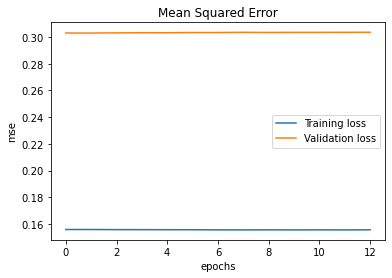

In [83]:
plt.plot(mlp_amt_be.history['mean_squared_error'], label = 'Training loss')
plt.plot(mlp_amt_be.history['val_mean_squared_error'], label = 'Validation loss')
plt.title('Mean Squared Error')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()

# iv. Test best model

In [84]:
# Y_pred = hypermodel.predict(X_test)   ### results from the hypermodel are giving fluctuating results
Y_pred = model.predict(X_test)   #### this giving betetr result(more stable)

14/14 [==============================] - 0s 3ms/step


In [85]:
Y_pred

array([[-6.3771212e-01],
       [-6.3373160e-01],
       [-6.3509816e-01],
       [-6.3452578e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-5.9384191e-01],
       [-2.6964700e-01],
       [-1.4899591e-01],
       [-2.0202550e-01],
       [-1.6755515e-01],
       [-2.7678274e-02],
       [ 2.6084793e-01],
       [ 2.5204487e-02],
       [ 6.1975367e-02],
       [-7.8334093e-02],
       [-1.6025895e-01],
       [-1.3752130e-01],
       [ 7.0970736e-02],
       [ 4.1892165e-01],
       [ 7.2578132e-01],
       [ 2.2267978e+00],
       [ 1.0072842e+00],
       [ 1.1350645e+00],
       [ 9.0210730e-01],
       [ 5.4682314e-01],
       [ 2.8348514e-01],
       [ 8.7030137e-01],
       [ 1.2789154e+00],
       [ 4.5058630e-02],
       [-5.0640292e-02],
       [-2.1608792e-02],


In [86]:
Y_pred.reshape(436,1)

array([[-6.3771212e-01],
       [-6.3373160e-01],
       [-6.3509816e-01],
       [-6.3452578e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-5.9384191e-01],
       [-2.6964700e-01],
       [-1.4899591e-01],
       [-2.0202550e-01],
       [-1.6755515e-01],
       [-2.7678274e-02],
       [ 2.6084793e-01],
       [ 2.5204487e-02],
       [ 6.1975367e-02],
       [-7.8334093e-02],
       [-1.6025895e-01],
       [-1.3752130e-01],
       [ 7.0970736e-02],
       [ 4.1892165e-01],
       [ 7.2578132e-01],
       [ 2.2267978e+00],
       [ 1.0072842e+00],
       [ 1.1350645e+00],
       [ 9.0210730e-01],
       [ 5.4682314e-01],
       [ 2.8348514e-01],
       [ 8.7030137e-01],
       [ 1.2789154e+00],
       [ 4.5058630e-02],
       [-5.0640292e-02],
       [-2.1608792e-02],


In [87]:
Y_pred.shape

(436, 1)

In [88]:
y_test

array([[-5.98808761e-01],
       [-6.00386034e-01],
       [-6.00386034e-01],
       [-5.98808761e-01],
       [-5.99860276e-01],
       [-5.97231489e-01],
       [-5.98808761e-01],
       [-6.00386034e-01],
       [-6.00386034e-01],
       [-6.01437548e-01],
       [-6.01963306e-01],
       [-6.03540578e-01],
       [-6.04592093e-01],
       [-6.05117850e-01],
       [-6.04592093e-01],
       [-5.86716341e-01],
       [-5.86716341e-01],
       [-5.60428470e-01],
       [-5.71995133e-01],
       [-5.78829979e-01],
       [-5.79355737e-01],
       [-5.74623920e-01],
       [-3.87454278e-01],
       [-4.44761837e-01],
       [-5.17316361e-01],
       [-4.87348188e-01],
       [-3.65372467e-01],
       [ 1.58807682e-01],
       [ 1.19901633e-01],
       [ 7.29254483e-01],
       [ 1.45663746e-01],
       [ 1.55653137e-01],
       [ 1.25159207e-01],
       [-3.43290655e-01],
       [-3.74836100e-01],
       [ 6.06753004e-01],
       [ 9.67683062e-02],
       [-4.00072456e-01],
       [-4.8

In [89]:
y_test.shape

(436, 1)

In [90]:
print(y_test[:,:-1].shape)   
print(y_test[:,1:2].shape)

(436, 0)
(436, 0)


In [91]:
y_test[:,-1:]    ##### all rows and all columns including -1(which is the last column)

array([[-5.98808761e-01],
       [-6.00386034e-01],
       [-6.00386034e-01],
       [-5.98808761e-01],
       [-5.99860276e-01],
       [-5.97231489e-01],
       [-5.98808761e-01],
       [-6.00386034e-01],
       [-6.00386034e-01],
       [-6.01437548e-01],
       [-6.01963306e-01],
       [-6.03540578e-01],
       [-6.04592093e-01],
       [-6.05117850e-01],
       [-6.04592093e-01],
       [-5.86716341e-01],
       [-5.86716341e-01],
       [-5.60428470e-01],
       [-5.71995133e-01],
       [-5.78829979e-01],
       [-5.79355737e-01],
       [-5.74623920e-01],
       [-3.87454278e-01],
       [-4.44761837e-01],
       [-5.17316361e-01],
       [-4.87348188e-01],
       [-3.65372467e-01],
       [ 1.58807682e-01],
       [ 1.19901633e-01],
       [ 7.29254483e-01],
       [ 1.45663746e-01],
       [ 1.55653137e-01],
       [ 1.25159207e-01],
       [-3.43290655e-01],
       [-3.74836100e-01],
       [ 6.06753004e-01],
       [ 9.67683062e-02],
       [-4.00072456e-01],
       [-4.8

## Evaluation metics

In [92]:
###nse

import hydroeval as he
nse = he.evaluator(he.nse, Y_pred, y_test[:,-1:]  )
print(nse)

[0.75641881]


In [93]:
##rmse
rmse = he.evaluator(he.rmse, Y_pred, y_test[:,-1:]  )
print(rmse)

[0.49297314]


In [94]:
###logrmse
from sklearn.metrics import mean_squared_error
#### log of predicted values
y_pred_lg = np.log1p(Y_pred)

#### log of test values
y_test_lg = np.log1p(y_test[:,-1:])


In [95]:
##calculate mse
mse = mean_squared_error(y_pred_lg, y_test_lg)
rmse_lg = np.sqrt(mse)   
print(rmse_lg)

0.41885575469928155


## v. plot

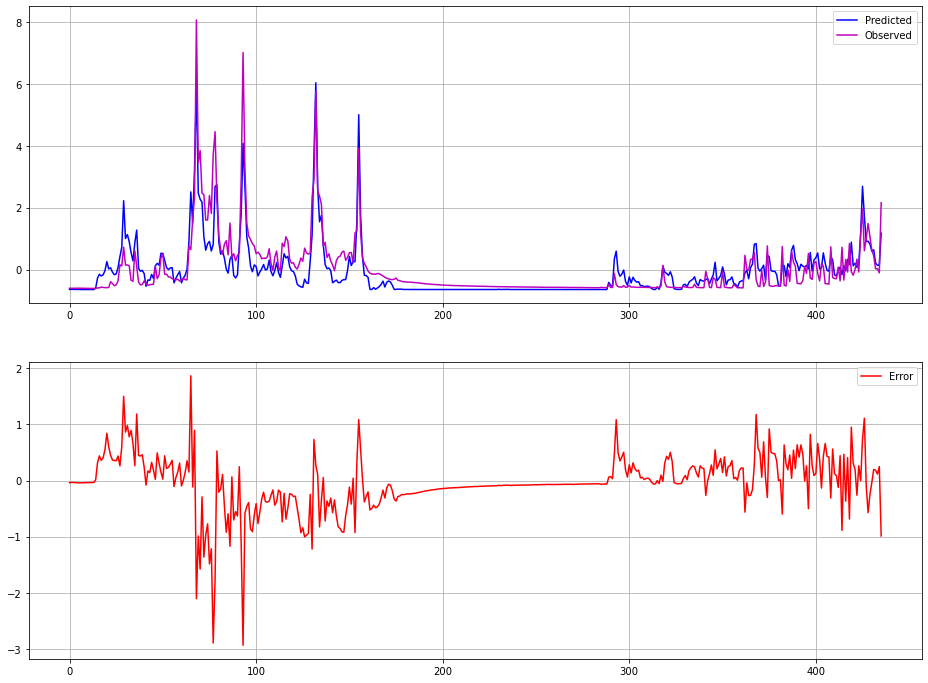

In [96]:
import matplotlib.pyplot as plt
# plt.plot(Q_pred)
# plt.plot(y_test)

plt.figure(figsize = (16, 12))

plt.subplot(2, 1, 1)

plt.plot(Y_pred[:,-1],'b', label = "Predicted")

plt.plot(y_test[:,-1], 'm',  label = "Observed")  

plt.legend()
plt.grid()

plt.subplot(2,1,2)

plt.plot(Y_pred[:,-1] - y_test[:,-1],'r', label = "Error")

plt.legend()

plt.grid()

##  save_model

# vi. Denormalize the data

In [97]:
#### Original data
df_train_norm

,Rt,Rt_1,Rt_2,Rt_3,Rt_4,Rt_5,Qt
0,-0.306768,1.345488,-0.120634,0.191968,-0.258026,1.555244,0.500865
1,-0.366809,-0.307482,1.345417,-0.120909,0.191917,-0.258825,0.091390
2,1.378816,-0.367498,-0.307591,1.345176,-0.120965,0.190866,-0.017104
3,2.156268,1.377410,-0.367608,-0.307870,1.345145,-0.121841,1.417809
4,0.056074,2.154542,1.377339,-0.367889,-0.307929,1.343448,0.798347
...,...,...,...,...,...,...,...
2035,-0.366809,-0.367498,-0.367608,-0.367889,-0.367949,-0.368686,-0.494825
2036,-0.366809,-0.367498,-0.367608,-0.367889,-0.367949,-0.368686,-0.494825
2037,-0.362091,-0.367498,-0.367608,-0.367889,-0.367949,-0.368686,-0.494825
2038,-0.327215,-0.362781,-0.367608,-0.367889,-0.367949,-0.368686,-0.496575


In [98]:
### normalized data after model training
Y_pred    #### model out put

array([[-6.3771212e-01],
       [-6.3373160e-01],
       [-6.3509816e-01],
       [-6.3452578e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-6.3952869e-01],
       [-5.9384191e-01],
       [-2.6964700e-01],
       [-1.4899591e-01],
       [-2.0202550e-01],
       [-1.6755515e-01],
       [-2.7678274e-02],
       [ 2.6084793e-01],
       [ 2.5204487e-02],
       [ 6.1975367e-02],
       [-7.8334093e-02],
       [-1.6025895e-01],
       [-1.3752130e-01],
       [ 7.0970736e-02],
       [ 4.1892165e-01],
       [ 7.2578132e-01],
       [ 2.2267978e+00],
       [ 1.0072842e+00],
       [ 1.1350645e+00],
       [ 9.0210730e-01],
       [ 5.4682314e-01],
       [ 2.8348514e-01],
       [ 8.7030137e-01],
       [ 1.2789154e+00],
       [ 4.5058630e-02],
       [-5.0640292e-02],
       [-2.1608792e-02],


In [99]:
def denormalize(data, original_data, type='min_max'):   ### default is min-max in this case(there is no reason behind this)

    if type == 'min_max':
        min = np.min(original_data)
        max = np.max(original_data)
        data = data * (max - min) + min
    elif type == 'z_score':
        mean = np.mean(original_data)
        std = np.std(original_data)
        data = data * std + mean
    elif type == 'max':                
        max = np.max(original_data)
        data = data * max
    else:
        raise ValueError("Invalid normalization type. Choose either 'max', 'min_max', or 'z_score'.")
    return data

In [100]:
Y_observ_unnorm = df_test['Qt']

Y_observ_unnorm = Y_observ_unnorm.to_numpy()

###  denormalize predicted discharge

In [101]:
### Standard denormalization (becasue we used standard(z-score) in this experiment)

Y_pred_denorm = denormalize(Y_pred, Y_observ_unnorm, type='z_score')

In [102]:
print(Y_pred_denorm)
print(Y_pred_denorm.shape)

[[   5.339699 ]
 [   6.095932 ]
 [   5.8363037]
 [   5.9450455]
 [   4.9945755]
 [   4.9945755]
 [   4.9945755]
 [   4.9945755]
 [   4.9945755]
 [   4.9945755]
 [   4.9945755]
 [   4.9945755]
 [   4.9945755]
 [   4.9945755]
 [  13.674316 ]
 [  75.26601  ]
 [  98.18773  ]
 [  88.112976 ]
 [  94.66178  ]
 [ 121.236084 ]
 [ 176.05132  ]
 [ 131.28294  ]
 [ 138.2688   ]
 [ 111.61231  ]
 [  96.047935 ]
 [ 100.36772  ]
 [ 139.97777  ]
 [ 206.08272  ]
 [ 264.381    ]
 [ 549.54944  ]
 [ 317.8619   ]
 [ 342.13806  ]
 [ 297.88004  ]
 [ 230.3819   ]
 [ 180.352    ]
 [ 291.83743  ]
 [ 369.46738  ]
 [ 135.0549   ]
 [ 116.87368  ]
 [ 122.38918  ]
 [ 102.39143  ]
 [  25.01873  ]
 [  63.36953  ]
 [  61.328506 ]
 [  97.01281  ]
 [  72.56122  ]
 [ 150.77853  ]
 [ 165.13533  ]
 [ 153.94208  ]
 [ 227.1139   ]
 [ 226.56851  ]
 [ 182.16707  ]
 [ 139.61977  ]
 [ 126.94265  ]
 [ 137.09155  ]
 [ 139.39915  ]
 [  46.024063 ]
 [  74.31147  ]
 [  96.38983  ]
 [ 115.59954  ]
 [  46.2731   ]
 [  74.33057  ]
 [  93.4

###  denormalize observed discharge

In [103]:
Y_obser_denorm = denormalize(y_test, Y_observ_unnorm, type='z_score')

In [104]:
### Standard denormalization (becasue we used standard(z-score) in this experiment)
Y_obser_denorm  

array([[  12.73068793],
       [  12.43103217],
       [  12.43103217],
       [  12.73068793],
       [  12.53091742],
       [  13.0303437 ],
       [  12.73068793],
       [  12.43103217],
       [  12.43103217],
       [  12.23126166],
       [  12.1313764 ],
       [  11.83172063],
       [  11.63195012],
       [  11.53206487],
       [  11.63195012],
       [  15.0280488 ],
       [  15.0280488 ],
       [  20.02231157],
       [  17.82483595],
       [  16.52632763],
       [  16.42644238],
       [  17.32540967],
       [  52.88456055],
       [  41.99706773],
       [  28.2129025 ],
       [  33.90636205],
       [  57.07974127],
       [ 156.66534078],
       [ 149.27383189],
       [ 265.04084274],
       [ 154.16820939],
       [ 156.06602924],
       [ 150.27268444],
       [  61.27492199],
       [  55.28180668],
       [ 241.76757826],
       [ 144.87888065],
       [  50.48731442],
       [  33.90636205],
       [  35.50452613],
       [  57.57916755],
       [  40.498

# Plot the denomalized data

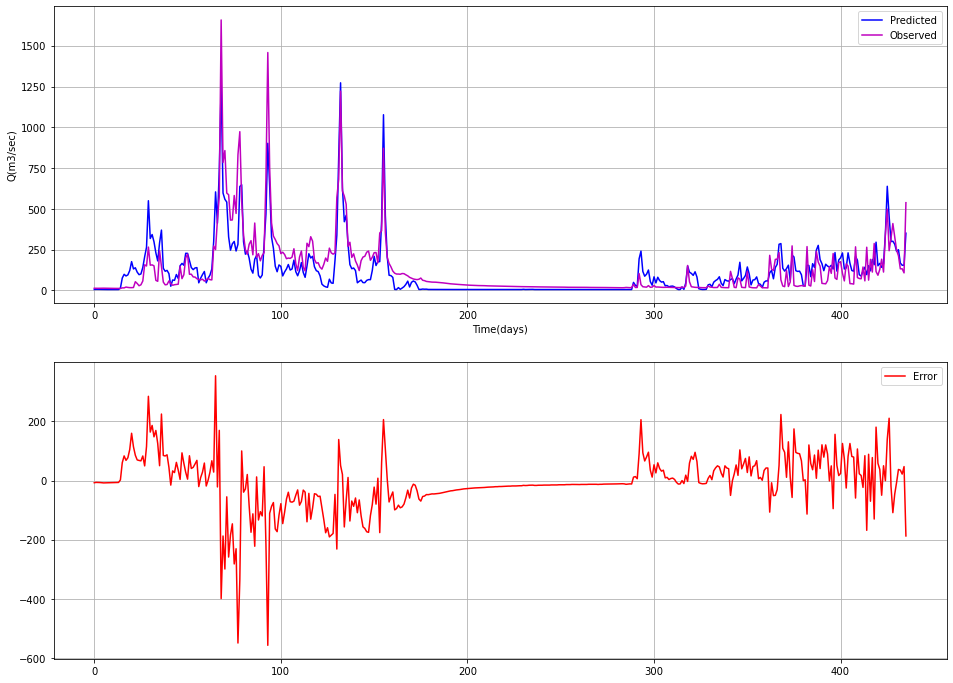

In [105]:
plt.figure(figsize = (16, 12))

plt.subplot(2, 1, 1)

plt.plot(Y_pred_denorm,'b', label = "Predicted")

plt.plot(Y_obser_denorm , 'm',  label = "Observed")  
plt.ylabel("Q(m3/sec)")
plt.xlabel("Time(days)")
plt.legend()
plt.grid()

plt.subplot(2,1,2)

plt.plot(Y_pred_denorm - Y_obser_denorm ,'r', label = "Error")

plt.legend()

plt.grid()

### NSE after denormalization

In [106]:
nse_d = he.evaluator(he.nse, Y_pred_denorm , Y_obser_denorm  )
print(nse_d)

[0.75641881]


### RMSE after denormalization (in m3/sec)

In [107]:
#### rmse in m3/sec
rmse_d = he.evaluator(he.rmse, Y_pred_denorm, Y_obser_denorm)
print(rmse_d)  

[93.65678257]


In [108]:
#### average value of discharge of the test data is 126.49m3/sec


In [109]:
df_test['Qt'].describe()

count     436.000000
mean      126.494495
std       190.201785
min        11.400000
25%        19.800000
50%        47.600000
75%       173.825000
max      1660.000000
Name: Qt, dtype: float64

### LogRMSE after denormalization 

In [110]:
###logrmse
from sklearn.metrics import mean_squared_error
#### log of predicted values
y_pred_lg = np.log1p(Y_pred_denorm)

#### log of test values
y_test_lg = np.log1p(Y_obser_denorm)

# 2) LSTM(03Feb2023)

In [111]:
#### Define model

import random
random.seed(1)

tf.random.set_seed(1) 
model_lstm = keras.Sequential()


model_lstm.add(tf.keras.layers.LSTM(units=8, input_shape=(n_steps_in, n_features), kernel_initializer = tf.keras.initializers.lecun_normal(seed = 1)))  #### 5 input features and 1 step at a time

# model_lstm.add(tf.keras.layers.Dropout(0.1))

model_lstm.add(tf.keras.layers.Dense((n_steps_out), kernel_initializer = tf.keras.initializers.lecun_normal(seed = 1)))
# model_lstm.add(tf.keras.layers.Dropout(0.1))

model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 8)                 480       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 489
Trainable params: 489
Non-trainable params: 0
_________________________________________________________________


In [112]:
### Compile

model_lstm.compile(optimizer='rmsprop',loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])


In [113]:
### fit
LSTM_12 = model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 400, verbose = True, shuffle = 0)

Epoch 1/400
64/64 [==============================] - 10s 25ms/step - loss: 0.9772 - mean_squared_error: 0.9772 - val_loss: 0.9285 - val_mean_squared_error: 0.9285
Epoch 2/400
64/64 [==============================] - 1s 8ms/step - loss: 0.9145 - mean_squared_error: 0.9145 - val_loss: 0.8514 - val_mean_squared_error: 0.8514
Epoch 3/400
64/64 [==============================] - 1s 8ms/step - loss: 0.8553 - mean_squared_error: 0.8553 - val_loss: 0.7789 - val_mean_squared_error: 0.7789
Epoch 4/400
64/64 [==============================] - 1s 8ms/step - loss: 0.8009 - mean_squared_error: 0.8009 - val_loss: 0.7148 - val_mean_squared_error: 0.7148
Epoch 5/400
64/64 [==============================] - 1s 8ms/step - loss: 0.7547 - mean_squared_error: 0.7547 - val_loss: 0.6604 - val_mean_squared_error: 0.6604
Epoch 6/400
64/64 [==============================] - 1s 9ms/step - loss: 0.7172 - mean_squared_error: 0.7172 - val_loss: 0.6140 - val_mean_squared_error: 0.6140
Epoch 7/400
64/64 [=============

64/64 [==============================] - 0s 5ms/step - loss: 0.2848 - mean_squared_error: 0.2848 - val_loss: 0.3040 - val_mean_squared_error: 0.3040
Epoch 102/400
64/64 [==============================] - 0s 4ms/step - loss: 0.2835 - mean_squared_error: 0.2835 - val_loss: 0.3038 - val_mean_squared_error: 0.3038
Epoch 103/400
64/64 [==============================] - 0s 5ms/step - loss: 0.2821 - mean_squared_error: 0.2821 - val_loss: 0.3036 - val_mean_squared_error: 0.3036
Epoch 104/400
64/64 [==============================] - 0s 7ms/step - loss: 0.2808 - mean_squared_error: 0.2808 - val_loss: 0.3035 - val_mean_squared_error: 0.3035
Epoch 105/400
64/64 [==============================] - 0s 4ms/step - loss: 0.2795 - mean_squared_error: 0.2795 - val_loss: 0.3033 - val_mean_squared_error: 0.3033
Epoch 106/400
64/64 [==============================] - 0s 5ms/step - loss: 0.2782 - mean_squared_error: 0.2782 - val_loss: 0.3032 - val_mean_squared_error: 0.3032
Epoch 107/400
64/64 [===============

64/64 [==============================] - 0s 5ms/step - loss: 0.1968 - mean_squared_error: 0.1968 - val_loss: 0.2941 - val_mean_squared_error: 0.2941
Epoch 202/400
64/64 [==============================] - 0s 7ms/step - loss: 0.1962 - mean_squared_error: 0.1962 - val_loss: 0.2940 - val_mean_squared_error: 0.2940
Epoch 203/400
64/64 [==============================] - 0s 5ms/step - loss: 0.1956 - mean_squared_error: 0.1956 - val_loss: 0.2940 - val_mean_squared_error: 0.2940
Epoch 204/400
64/64 [==============================] - 0s 4ms/step - loss: 0.1950 - mean_squared_error: 0.1950 - val_loss: 0.2939 - val_mean_squared_error: 0.2939
Epoch 205/400
64/64 [==============================] - 0s 4ms/step - loss: 0.1944 - mean_squared_error: 0.1944 - val_loss: 0.2938 - val_mean_squared_error: 0.2938
Epoch 206/400
64/64 [==============================] - 1s 8ms/step - loss: 0.1938 - mean_squared_error: 0.1938 - val_loss: 0.2937 - val_mean_squared_error: 0.2937
Epoch 207/400
64/64 [===============

64/64 [==============================] - 0s 4ms/step - loss: 0.1523 - mean_squared_error: 0.1523 - val_loss: 0.2968 - val_mean_squared_error: 0.2968
Epoch 302/400
64/64 [==============================] - 0s 5ms/step - loss: 0.1520 - mean_squared_error: 0.1520 - val_loss: 0.2969 - val_mean_squared_error: 0.2969
Epoch 303/400
64/64 [==============================] - 0s 5ms/step - loss: 0.1517 - mean_squared_error: 0.1517 - val_loss: 0.2970 - val_mean_squared_error: 0.2970
Epoch 304/400
64/64 [==============================] - 0s 5ms/step - loss: 0.1514 - mean_squared_error: 0.1514 - val_loss: 0.2970 - val_mean_squared_error: 0.2970
Epoch 305/400
64/64 [==============================] - 0s 5ms/step - loss: 0.1510 - mean_squared_error: 0.1510 - val_loss: 0.2971 - val_mean_squared_error: 0.2971
Epoch 306/400
64/64 [==============================] - 0s 4ms/step - loss: 0.1507 - mean_squared_error: 0.1507 - val_loss: 0.2971 - val_mean_squared_error: 0.2971
Epoch 307/400
64/64 [===============

In [114]:
#### find the best epoch by looking in to the validation loss
### in this case the best epoch is too small that the results are not turning out to be good.

val_loss_per_epoch = LSTM_12.history['val_loss']   

#### 'val_loss' should align with the objective function used when applying 'tuner.search' (both should be loss or both accuracy)

best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1

print('Best epoch: %d' % (best_epoch,))

Best epoch: 250


In [115]:
#### model with best epoch
LSTM_be = model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = best_epoch, verbose = True, shuffle = 0)


Epoch 1/250
64/64 [==============================] - 0s 4ms/step - loss: 0.1291 - mean_squared_error: 0.1291 - val_loss: 0.2976 - val_mean_squared_error: 0.2976
Epoch 2/250
64/64 [==============================] - 0s 4ms/step - loss: 0.1290 - mean_squared_error: 0.1290 - val_loss: 0.2976 - val_mean_squared_error: 0.2976
Epoch 3/250
64/64 [==============================] - 0s 4ms/step - loss: 0.1288 - mean_squared_error: 0.1288 - val_loss: 0.2976 - val_mean_squared_error: 0.2976
Epoch 4/250
64/64 [==============================] - 0s 5ms/step - loss: 0.1286 - mean_squared_error: 0.1286 - val_loss: 0.2976 - val_mean_squared_error: 0.2976
Epoch 5/250
64/64 [==============================] - 0s 6ms/step - loss: 0.1285 - mean_squared_error: 0.1285 - val_loss: 0.2976 - val_mean_squared_error: 0.2976
Epoch 6/250
64/64 [==============================] - 0s 6ms/step - loss: 0.1283 - mean_squared_error: 0.1283 - val_loss: 0.2976 - val_mean_squared_error: 0.2976
Epoch 7/250
64/64 [===============

64/64 [==============================] - 0s 5ms/step - loss: 0.1152 - mean_squared_error: 0.1152 - val_loss: 0.2884 - val_mean_squared_error: 0.2884
Epoch 102/250
64/64 [==============================] - 0s 4ms/step - loss: 0.1151 - mean_squared_error: 0.1151 - val_loss: 0.2883 - val_mean_squared_error: 0.2883
Epoch 103/250
64/64 [==============================] - 0s 3ms/step - loss: 0.1150 - mean_squared_error: 0.1150 - val_loss: 0.2882 - val_mean_squared_error: 0.2882
Epoch 104/250
64/64 [==============================] - 0s 3ms/step - loss: 0.1149 - mean_squared_error: 0.1149 - val_loss: 0.2881 - val_mean_squared_error: 0.2881
Epoch 105/250
64/64 [==============================] - 0s 3ms/step - loss: 0.1149 - mean_squared_error: 0.1149 - val_loss: 0.2881 - val_mean_squared_error: 0.2881
Epoch 106/250
64/64 [==============================] - 0s 3ms/step - loss: 0.1148 - mean_squared_error: 0.1148 - val_loss: 0.2880 - val_mean_squared_error: 0.2880
Epoch 107/250
64/64 [===============

64/64 [==============================] - 0s 3ms/step - loss: 0.1083 - mean_squared_error: 0.1083 - val_loss: 0.2848 - val_mean_squared_error: 0.2848
Epoch 202/250
64/64 [==============================] - 0s 3ms/step - loss: 0.1083 - mean_squared_error: 0.1083 - val_loss: 0.2848 - val_mean_squared_error: 0.2848
Epoch 203/250
64/64 [==============================] - 0s 3ms/step - loss: 0.1082 - mean_squared_error: 0.1082 - val_loss: 0.2848 - val_mean_squared_error: 0.2848
Epoch 204/250
64/64 [==============================] - 0s 3ms/step - loss: 0.1082 - mean_squared_error: 0.1082 - val_loss: 0.2847 - val_mean_squared_error: 0.2847
Epoch 205/250
64/64 [==============================] - 0s 3ms/step - loss: 0.1081 - mean_squared_error: 0.1081 - val_loss: 0.2847 - val_mean_squared_error: 0.2847
Epoch 206/250
64/64 [==============================] - 0s 4ms/step - loss: 0.1080 - mean_squared_error: 0.1080 - val_loss: 0.2846 - val_mean_squared_error: 0.2846
Epoch 207/250
64/64 [===============

In [116]:
### Predict
Y_pred_lstm = model_lstm.predict(X_test)

14/14 [==============================] - 1s 3ms/step


In [117]:
import hydroeval as he
nse_ls = he.evaluator(he.nse, Y_pred_lstm, y_test[:,-1:]  )
print(nse_ls)

[0.71654917]


In [118]:
##rmse
rmse_ls = he.evaluator(he.rmse,Y_pred_lstm, y_test[:,-1:]  )
print(rmse_ls)

[0.53179011]


In [119]:
###logrmse
from sklearn.metrics import mean_squared_error
#### log of predicted values
y_pred_lg_ls = np.log1p(Y_pred_lstm)

#### log of test values
y_test_lg = np.log1p(y_test[:,-1:])

In [120]:
##calculate mse
mse_ls = mean_squared_error(y_pred_lg_ls, y_test_lg)
rmse_lg_ls = np.sqrt(mse_ls)   
print(rmse_lg_ls)

0.3975015715508967


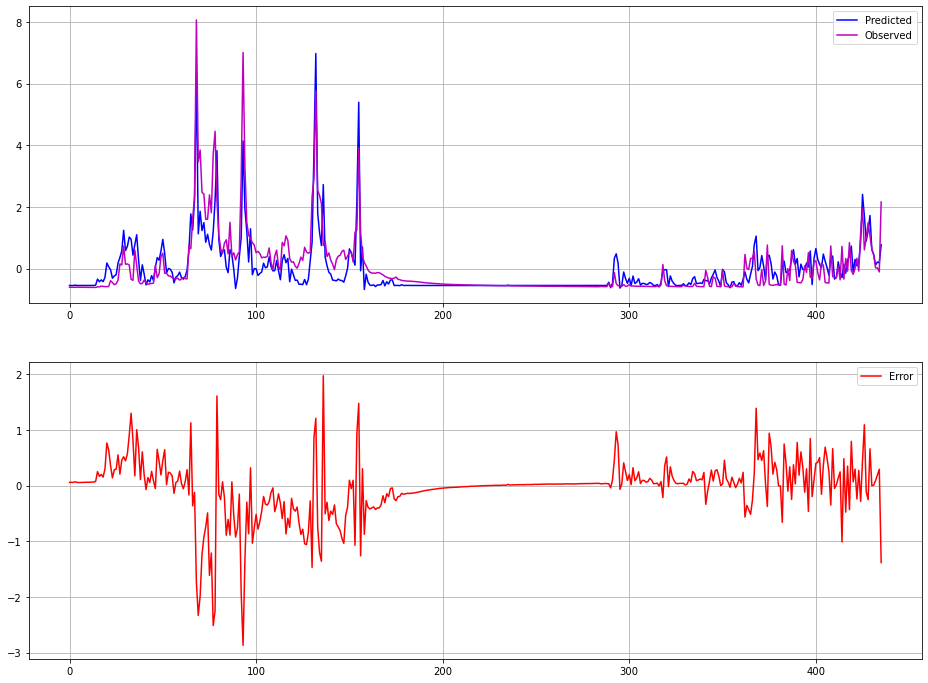

In [121]:
plt.figure(figsize = (16, 12))

plt.subplot(2, 1, 1)

plt.plot(Y_pred_lstm,'b', label = "Predicted")

plt.plot(y_test, 'm',  label = "Observed")  

plt.legend()
plt.grid()

plt.subplot(2,1,2)

plt.plot(Y_pred_lstm - y_test,'r', label = "Error")

plt.legend()

plt.grid()

# Denormalized results

In [122]:
### denormalize predicted discharge (based on Z-score)

Y_pred_denorm_lstm = denormalize(Y_pred_lstm, Y_observ_unnorm, type='z_score')

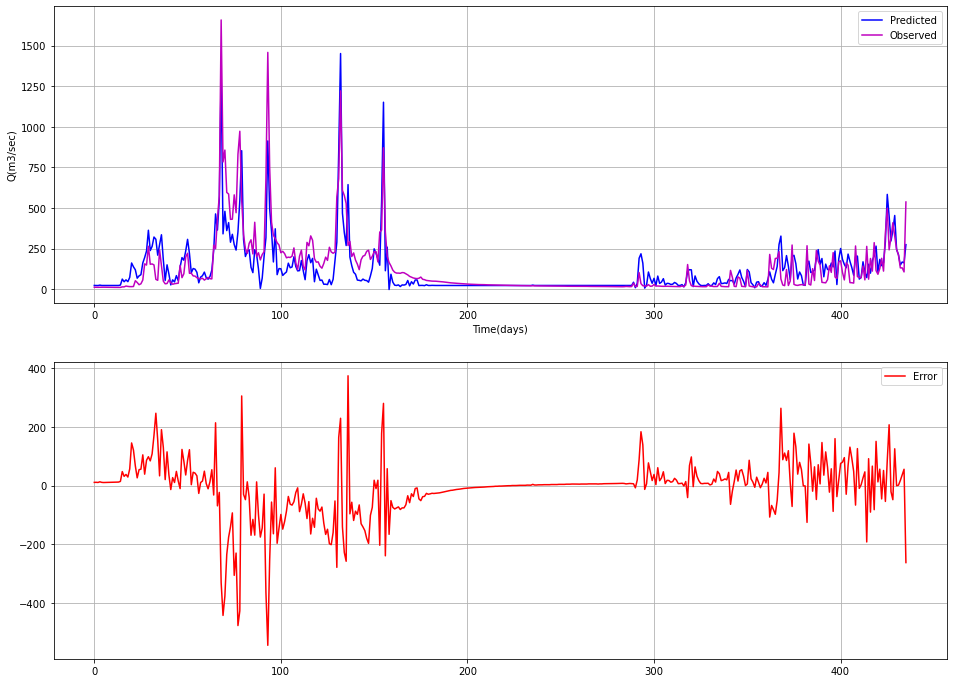

In [123]:
## plot after denormalization
plt.figure(figsize = (16, 12))

plt.subplot(2, 1, 1)

plt.plot(Y_pred_denorm_lstm,'b', label = "Predicted")

plt.plot(Y_obser_denorm , 'm',  label = "Observed")  
plt.ylabel("Q(m3/sec)")
plt.xlabel("Time(days)")
plt.legend()
plt.grid()

plt.subplot(2,1,2)

plt.plot(Y_pred_denorm_lstm - Y_obser_denorm ,'r', label = "Error")

plt.legend()

plt.grid()

In [124]:
nse_d_ls = he.evaluator(he.nse, Y_pred_denorm_lstm , Y_obser_denorm  )
print(nse_d_ls)

[0.71654917]


In [125]:
rmse_d_ls = he.evaluator(he.rmse,  Y_pred_denorm_lstm , Y_obser_denorm)
print(rmse_d_ls)

[101.0313658]


# 3. XGBoost

#### a. Define model 

In [126]:
# df_train_norm 
# df_val_norm
df_test_norm 

,Rt,Rt_1,Rt_2,Rt_3,Rt_4,Rt_5,Qt
2476,-0.464957,-0.465583,-0.450549,-0.463336,-0.463232,-0.461678,-0.598809
2477,-0.464957,-0.465583,-0.464889,-0.448999,-0.463232,-0.461678,-0.600386
2478,-0.464957,-0.465583,-0.464889,-0.463336,-0.448896,-0.461678,-0.600386
2479,-0.464957,-0.465583,-0.464889,-0.463336,-0.463232,-0.447345,-0.598809
2480,-0.464957,-0.465583,-0.464889,-0.463336,-0.463232,-0.461678,-0.599860
...,...,...,...,...,...,...,...
2907,0.152605,0.762118,-0.080644,1.173496,0.973538,0.497776,0.449552
2908,-0.428405,0.169604,0.762575,-0.079174,1.173537,0.974788,0.028946
2909,0.151306,-0.427989,0.170175,0.763865,-0.079084,1.174745,0.028946
2910,-0.194892,0.168268,-0.427302,0.171592,0.763922,-0.077612,-0.102494


In [127]:
####training data

x_train_xg = df_train_norm.iloc[:,0:6]
y_train_xg = df_train_norm.iloc[:,6]

In [128]:
## Validation
x_val_xg = df_val_norm.iloc[:,0:6]
y_val_xg = df_val_norm.iloc[:,6]

In [129]:
###test data
x_test_xg = df_test_norm .iloc[:,0:6]
y_test_xg = df_test_norm .iloc[:,6]

In [130]:
import xgboost as xgb

model_xg = xgb.XGBRegressor()


In [131]:
X_train.shape

(2040, 1, 6)

In [132]:
### Model.fit

M_XGB_1 = model_xg.fit(x_train_xg, y_train_xg)

In [133]:
Y_pred_xg = model_xg.predict(x_test_xg) 

In [134]:
Y_pred_xg

array([-4.24928665e-01, -4.24928665e-01, -4.24928665e-01, -4.24928665e-01,
       -4.24928665e-01, -4.24928665e-01, -4.24928665e-01, -4.24928665e-01,
       -4.24928665e-01, -4.24928665e-01, -4.24928665e-01, -4.24928665e-01,
       -4.24928665e-01, -4.24928665e-01, -4.65332717e-01, -3.85998696e-01,
       -2.83303529e-01, -3.77035253e-02, -3.78522761e-02,  2.52098769e-01,
        4.20924604e-01, -6.37321100e-02,  1.82334129e-02, -5.64399600e-01,
       -2.97454000e-01, -1.99982300e-01, -1.03016473e-01,  5.75445354e-01,
        8.73839140e-01,  1.63468206e+00,  7.43935943e-01,  1.38554966e+00,
        1.26878095e+00,  8.26024413e-01,  8.52894008e-01,  6.81852698e-01,
        1.51518643e+00,  2.17316836e-01, -7.88506120e-02,  1.11866571e-01,
       -5.75231425e-02, -4.37625766e-01, -9.08696130e-02, -1.28319308e-01,
        2.14733873e-02, -3.17403972e-01, -1.82328150e-02, -1.38453856e-01,
        7.46635199e-02,  5.68566859e-01,  9.28749681e-01,  2.78800339e-01,
        2.15528995e-01,  

In [135]:
import hydroeval as he
nse_xg = he.evaluator(he.nse, Y_pred_xg, y_test_xg  )
print(nse_xg)

[0.69710933]
